In [141]:
#IANNWTF HOMEWORK03
#Author: Yu Xuan, Diong


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot


In [142]:
class Model(Model):
  def __init__(self):
    super(Model, self).__init__()
    #initialize two hidden layers, each with 256 perceptrons using the sigmoid function as activation function
    #initialize output layer with 10 units. softmax is used as activation function
    self.hidden_L1 = Dense(units=256, activation=tf.keras.activations.sigmoid, use_bias = True)
    self.hidden_L2 = Dense(units=256, activation=tf.keras.activations.sigmoid, use_bias = True)
    self.output_L = Dense(units=10, activation=tf.keras.activations.softmax, use_bias = True)

  def call(self, inputs):
    x = self.hidden_L1(inputs)
    x = self.hidden_L2(x)
    x = self.output_L(x)
    return x


In [143]:
def test(model, test_data, loss_function):

    test_losses = []
    test_accuracies = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        # axis=0 is the batch_size, axis=1 is the one-hot encoding of the labels
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_losses.append(sample_test_loss)
        test_accuracies.append(sample_test_accuracy)

    test_loss = np.mean(test_losses)
    test_accuracy = np.mean(test_accuracies)

    return test_loss, test_accuracy

def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [144]:
train_ds, test_ds = tfds.load('genomics_ood', split=['train[:10%]', 'test[:1%]'], shuffle_files=True, as_supervised=True, download=False)


In [145]:
#Data mapping and formatting

train_ds = train_ds.map(lambda seq, label: (onehotify(seq),tf.one_hot(label, 10)))
test_ds = test_ds.map(lambda seq, label: (onehotify(seq), tf.one_hot(label, 10)))

# load data points 100 by 100 at each iteration
train_ds = train_ds.batch(100)
train_ds = train_ds.shuffle(buffer_size=100)
# always have one batch ready to be loaded
train_ds = train_ds.prefetch(1)

test_ds = test_ds.batch(10)
test_ds = test_ds.shuffle(buffer_size=10)
test_ds = test_ds.prefetch(1)

In [148]:
#Defining hyperparameters

num_epochs = 10
learning_rate = 0.1

cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

#Initialize lists for visualizations
train_losses = []
test_losses = []
test_accuracies = []

#Initialize model
model = Model()

#Pre-training test
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)

#appending pre-training test results
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before start
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

#Training in epochs
for epoch in range(num_epochs):
  print("Epoch: ", epoch)
  train_ds = train_ds.shuffle(buffer_size=100)
  test_ds = test_ds.shuffle(buffer_size=100)

  #training step
  for (input, target) in train_ds:
    train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
  train_losses.append(train_loss)

  #test in each epoch
  test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


<Figure size 432x288 with 0 Axes>

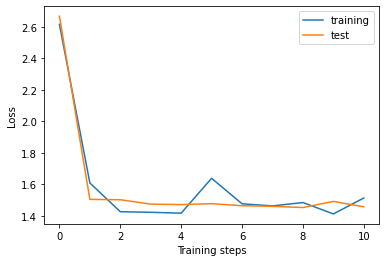

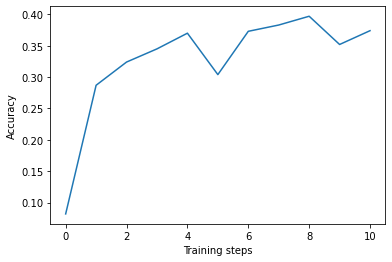

In [149]:
#Training visualization
#Top plot denotes losses for training and tests
#Bottom plot denotes accuracies for training and tests

plt.figure()
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2), ("training", "test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()